In [3]:
import sys
print(sys.executable)

/home/at3ee/anaconda3/bin/python


In [4]:
import arviz as az
import theano
import pymc3 as pm


In [5]:
az.style.use("arviz-darkgrid")

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use("ggplot")
warnings.filterwarnings('ignore')


In [7]:
num_schools = 8  # number of schools
treatment_effects = np.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)  # treatment effects
treatment_stddevs = np.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)  # treatment SE


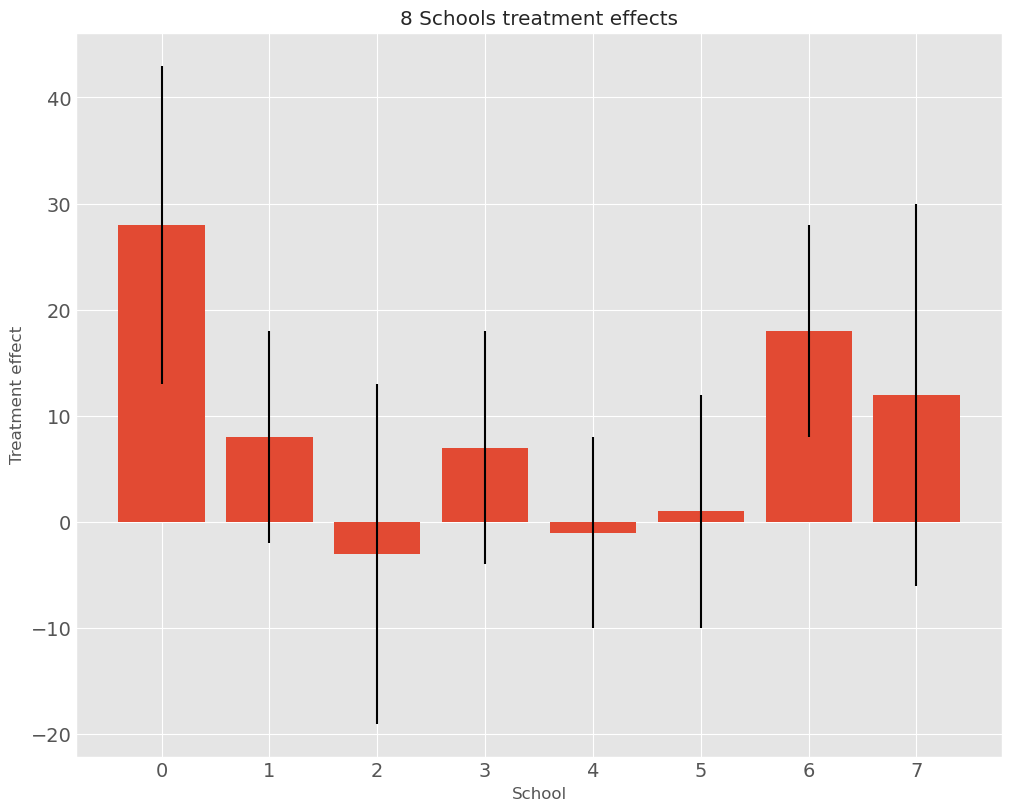

In [9]:
num_schools = 8  # number of schools
treatment_effects = np.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)  # treatment effects
treatment_stddevs = np.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)  # treatment SE

fig, ax = plt.subplots()
plt.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
plt.title("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
fig.set_size_inches(10, 8)
plt.show()


## 1. Non-centered Parameterization
### 1.1. Variational inference


In [16]:
# Parameterization by MCMC
with pm.Model() as model:
    eta = pm.Normal("eta", 0, 1, shape=num_schools)
    mu = pm.Normal("mu", 0, sigma=10)
    tau = pm.HalfNormal("tau", 10)

    theta = pm.Deterministic("theta", mu + tau * eta)

    obs = pm.Normal("obs", theta, sigma=treatment_stddevs, observed=treatment_effects)

    trace_h = pm.sample(2000, target_accept=0.95, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu, eta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


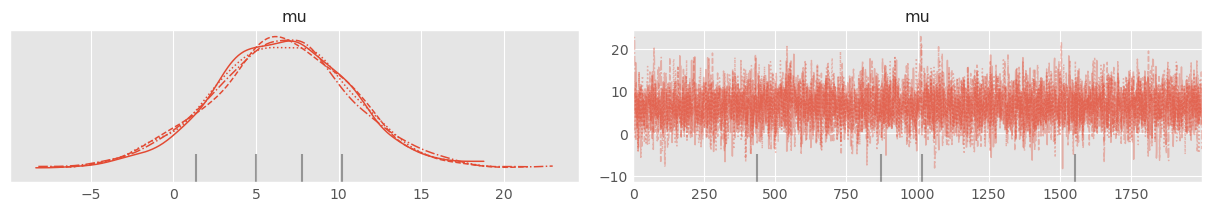

In [15]:
az.plot_trace(trace_h, var_names="mu");

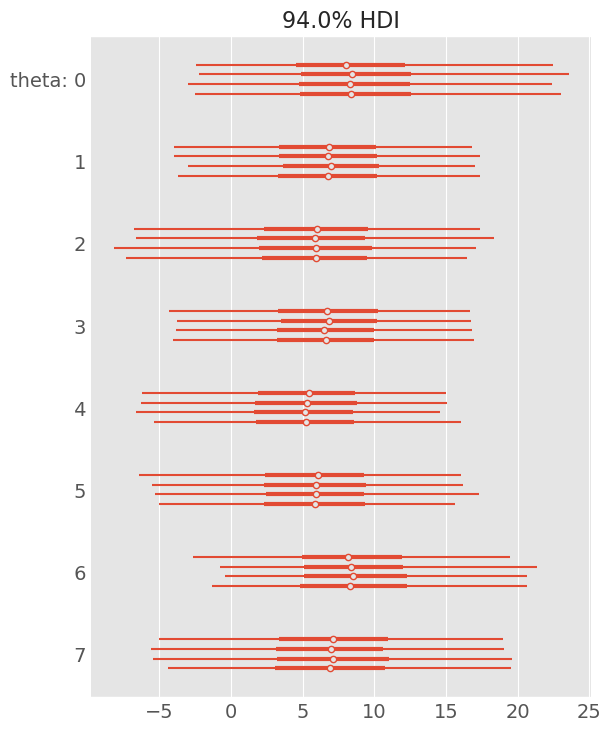

In [17]:
az.plot_forest(trace_h, var_names="theta");

### 1.2. ADVI Inference 
#### 1.2.1. KL-divergence

In [49]:
# Code is the same as in previous code block, except for:
from pymc3.variational.callbacks import CheckParametersConvergence

with model:
    fit = pm.fit(100_000, method='advi', callbacks=[CheckParametersConvergence()])

    
draws = fit.sample(2_000) # This will automatically check parameters convergence

Finished [100%]: Average Loss = 59.341


In [2]:
{cite}`perez2011python`

SyntaxError: invalid syntax (<ipython-input-2-745db45a1f9e>, line 1)

#### 1.2.2. $f$-divergence
Let ${\mathcal D}=\{x_{i}\}_{i=1}^{N}$ are $N$ observations.
The $f$-divergence between probability density functions, $q(\theta)$ and $p(\theta \vert \mathcal{D})$ is defined as,
$$
D_f(q(\theta) \parallel p(\theta \vert \mathcal{D})) = \int_\theta f \left(\frac{q(\theta)}{p(\theta \vert \mathcal{D})}\right) p(\theta \vert D)d\theta = \mathbb{E}_p \left[f \left(\frac{q(\theta)}{p(\theta\Vert \mathcal{D})}\right)\right]
$$
with $f(.)$ a convex function and $f(1)=0$.
A common instance of the $f$-divergence is the $\chi$-divergence: $f(x) = (x-1)^2$.

For VI using $\chi$-divergence, it is proposed to minimize {ref [1]}, 
$$
D_{\chi^2}(p\parallel q) = \mathbb{E}_{q(\mathbf{z};\mathbf{\Theta})}\left[\left(\frac{p(\mathbf{z}\vert \mathcal{D})}{q(\mathbf{z};\mathbf{\Theta})}\right)^2 - 1 \right]
$$